In [1]:
import pandas as pd
from sklearn.model_selection import (
    StratifiedShuffleSplit, GridSearchCV, 
    train_test_split, cross_validate, cross_val_score
)
from lightgbm import LGBMClassifier
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.datasets import fetch_megafon
from sklift.metrics import make_uplift_scorer
import os
import sys
from pathlib import Path
import yaml
from datetime import datetime
import re

c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cwd = Path.cwd()
repo_root = ([cwd] + list(cwd.parents))[1]

# Ensure repo_root is on sys.path so `src.train` can be imported
sys.path.append(str(repo_root))
from src.process_datasets import create_data, get_web_feats

# Load the YAML config file
with open(os.path.join(repo_root, "config.yaml"), "r") as f:
    config = yaml.safe_load(f)

In [3]:
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans column names: replaces whitespace with underscores,
    removes special characters, and ensures valid Python identifiers.
    """
    new_columns = []
    for col in df.columns:
        # 1. Replace whitespace with underscores
        clean_col = re.sub(r"\s+", "_", col)
        # 2. Remove non-alphanumeric characters except underscore
        clean_col = re.sub(r"[^\w]", "", clean_col)
        # 3. Ensure it doesn't start with a number
        if re.match(r"^\d", clean_col):
            clean_col = "_" + clean_col
        new_columns.append(clean_col)
    df.columns = new_columns
    return df

In [4]:
X_train, y_train, X_test, y_test, train, test = create_data(repo_root, config)
for df in [X_train, X_test]:
    df = clean_column_names(df)
y_train = train["churn"].astype(int)
treatment_train = train["outreach"].astype(int)

y_test = test["churn"].astype(int)
treatment_test = test["outreach"].astype(int)

print(f"\nTraining data: {len(X_train)} samples; test data: {len(X_test)} samples")
print(
    f"Treatment in train: {treatment_train.sum()} / {len(treatment_train)} ({100*treatment_train.mean():.1f}%)"
)
print(
    f"Treatment in test: {treatment_test.sum()} / {len(treatment_test)} ({100*treatment_test.mean():.1f}%)"
)

# Choose uplift method (two-model vs meta-learner S-learner)
uplift_method = config.get("uplift_method", "two_model")
models_dir = os.path.join(repo_root, "models")
os.makedirs(models_dir, exist_ok=True)
outputs_dir = os.path.join(repo_root, "outputs")
os.makedirs(outputs_dir, exist_ok=True)
timestamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")

Aggregating train features...
Aggregating test features...
Training data: 10000 samples; test data: 10000 samples
Preprocessing complete.
X_train -> (10000, 58) -> (10000, 58)
X_test  -> (10000, 58) -> (10000, 58)

Training data: 10000 samples; test data: 10000 samples
Treatment in train: 3984 / 10000 (39.8%)
Treatment in test: 3889 / 10000 (38.9%)


c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
from datetime import datetime

In [6]:
# dataset = fetch_megafon()
# data, treatment, target = dataset.data, dataset.treatment, dataset.target
# data = data.set_index('id')
X_train.drop(X_train.filter(regex="outreach").columns, axis=1,inplace=True)
X_test.drop(X_test.filter(regex="outreach").columns, axis=1,inplace=True)
# X_train.drop(columns=["outreach"], inplace=True)
# X_test.drop(columns=["outreach"], inplace=True)
X_train.head()

,num__member_tenure_days,num__session_count,num__recency_last_app_days,num__avg_session_duration,num__app_active_days,num__prop_active_days_app,num__total_visits,num__domain_careportal,num__domain_examplecom,num__domain_guidewellness,...,num__unique_icd_count,num__has_E11_9,num__has_I10,num__has_Z71_3,cat__tenure_long_False,cat__tenure_long_True,cat__tenure_mid_False,cat__tenure_mid_True,cat__tenure_bin_long,cat__tenure_bin_mid
0,1.040788,-1.041703,-0.399366,0.0,-0.467383,-0.467383,-1.330597,-1.054848,-1.205246,-1.059017,...,0.222017,0.837066,0.835858,0.834305,0.0,1.0,1.0,0.0,1.0,0.0
1,-1.189539,0.060949,-0.399366,0.0,0.016150,0.016150,-0.982486,0.187563,-0.903633,-0.222279,...,0.222017,0.837066,0.835858,0.834305,1.0,0.0,0.0,1.0,0.0,1.0
2,-0.084422,-0.214714,0.384704,0.0,0.499683,0.499683,1.512311,0.187563,0.906046,3.124673,...,-1.057620,0.837066,-1.196376,-1.198602,0.0,1.0,1.0,0.0,1.0,0.0
3,1.013997,0.060949,-0.007331,0.0,0.499683,0.499683,-0.634375,-0.640711,-0.300407,-0.222279,...,-1.057620,-1.194648,0.835858,-1.198602,0.0,1.0,1.0,0.0,1.0,0.0
4,1.248416,0.060949,-0.007331,0.0,0.499683,0.499683,-0.866449,-0.226574,-0.903633,-0.222279,...,0.222017,0.837066,0.835858,0.834305,0.0,1.0,1.0,0.0,1.0,0.0


---

### 1) Conditional Independence Assumption:

intuition: check if treatment was random

In [7]:
f1_micro = cross_val_score(
    X=X_train,
    y=treatment_train,
    estimator=LGBMClassifier(random_state=42, n_jobs=-1),
    scoring="f1_micro",
    cv=3,
)

print(f'F1 micro {f1_micro.mean():.2f}')

[LightGBM] [Info] Number of positive: 2656, number of negative: 4010
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1067
[LightGBM] [Info] Number of data points in the train set: 6666, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398440 -> initscore=-0.411970
[LightGBM] [Info] Start training from score -0.411970
[LightGBM] [Info] Number of positive: 2656, number of negative: 4011
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 6667, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398380 -> initscore=-0.412219
[LightGBM] [Info] Start training from score -0.412219
[LightGBM] [Info] 

In [8]:
X_train.groupby(treatment_train).mean()

,num__member_tenure_days,num__session_count,num__recency_last_app_days,num__avg_session_duration,num__app_active_days,num__prop_active_days_app,num__total_visits,num__domain_careportal,num__domain_examplecom,num__domain_guidewellness,...,num__unique_icd_count,num__has_E11_9,num__has_I10,num__has_Z71_3,cat__tenure_long_False,cat__tenure_long_True,cat__tenure_mid_False,cat__tenure_mid_True,cat__tenure_bin_long,cat__tenure_bin_mid
outreach,,,,,,,,,,,,,,,,,,,,,
0,0.031365,0.193374,-0.030074,0.0,0.171755,0.171755,-0.009354,0.008718,-0.018396,-0.000090,...,-0.002706,0.003577,0.002155,-0.008459,0.323969,0.676031,0.676031,0.323969,0.676031,0.323969
1,-0.047363,-0.292002,0.045413,0.0,-0.259357,-0.259357,0.014125,-0.013165,0.027779,0.000137,...,0.004087,-0.005402,-0.003255,0.012774,0.360693,0.639307,0.639307,0.360693,0.639307,0.360693


Based on the user's features, the classifier makes type I and type II errors as often (50%) as it guesses the correct answer. This means that communication was carried out by random.

### 2) Fit single model with treatment feature (S-Learner approach) ([link to tutorial](https://habr.com/ru/company/ru_mts/blog/485980/))

intuition: the model fits simultaneously on two groups with binary treatment flag as an additional user's feature. We score each object from the test sample twice: with the treatment flag equal to 1 and equal to 0. Subtracting the probabilities for each observation, we obtain an estimated uplift.

In [9]:
stratify_cols = pd.concat([treatment_train, y_train], axis=1)

X_cv, X_test, y_cv, y_test, trmnt_cv, trmnt_test = train_test_split(
    X_train, y_train, treatment_train, stratify=stratify_cols, test_size=0.2, random_state=42
)

In [10]:
# setting up model ...
estimator = LGBMClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

# ... metamodel ...
slearner = SoloModel(estimator=estimator)

# ... and uplift metric scorer to pass to cross validation
uplift_scorer = make_uplift_scorer("qini_auc_score", trmnt_cv)

In [11]:
cv_gen = StratifiedShuffleSplit(
    n_splits=3,
    random_state=42
)

cross_validate(
    slearner,
    X=X_cv,
    y=y_cv,
    scoring=uplift_scorer,
    return_estimator=True,
    cv=cv_gen,
    n_jobs=-1,
    fit_params={"treatment": trmnt_cv},
)

{'fit_time': array([0.46868324, 0.46868324, 0.39471412]),
 'score_time': array([0.00975561, 0.01176167, 0.00976706]),
 'estimator': [SoloModel(estimator=LGBMClassifier(class_weight='balanced', n_jobs=-1,
                                     random_state=42)),
  SoloModel(estimator=LGBMClassifier(class_weight='balanced', n_jobs=-1,
                                     random_state=42)),
  SoloModel(estimator=LGBMClassifier(class_weight='balanced', n_jobs=-1,
                                     random_state=42))],
 'test_score': array([-0.01205872,  0.03332011,  0.03128963])}

In [12]:
grid = {
    "estimator__learning_rate": [ 0.05, 0.1],
    "estimator__max_depth": [6, 8,16,32],
}

grid_search = GridSearchCV(slearner,
                           param_grid=grid,
                           scoring=uplift_scorer,
                           n_jobs=-1,
                           cv=cv_gen,
                           return_train_score=True
                          )

grid_search = grid_search.fit(X=X_cv, y=y_cv, treatment=trmnt_cv)

[LightGBM] [Info] Number of positive: 1616, number of negative: 6384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


In [13]:
print(f"best qini score on grid search: {grid_search.best_score_:.4f}")
print(f"best params: {grid_search.best_params_}")

best qini score on grid search: 0.0333
best params: {'estimator__learning_rate': 0.05, 'estimator__max_depth': 32}


In [14]:
slearner.set_params(**grid_search.best_params_)

slearner.fit(
    X=X_cv, 
    y=y_cv, 
    treatment=trmnt_cv,
)
uplift = slearner.predict(X_test)

[LightGBM] [Info] Number of positive: 1616, number of negative: 6384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Text(0.5, 0.98, 'Qini curve')

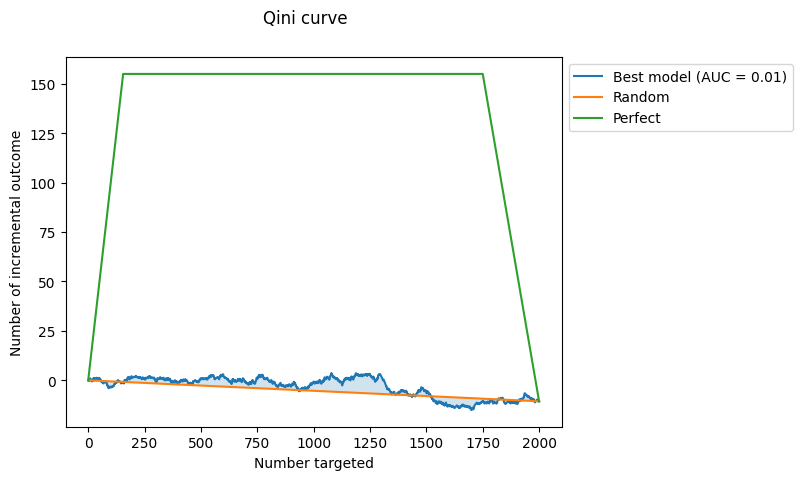

In [15]:
bets_disp = plot_qini_curve(y_test, uplift, trmnt_test, perfect=True, name="Best model")
bets_disp.figure_.suptitle("Qini curve")

Params: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100} | CV Qini AUC: -0.0259
Params: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200} | CV Qini AUC: -0.0260
Params: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100} | CV Qini AUC: -0.0259
Params: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200} | CV Qini AUC: -0.0260
Params: {'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100} | CV Qini AUC: -0.0258
Params: {'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200} | CV Qini AUC: -0.0260
Params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100} | CV Qini AUC: -0.0246
Params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200} | CV Qini AUC: -0.0243
Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100} | CV Qini AUC: -0.0230
Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200} | CV Qini AUC: -0.0241
Params: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 10

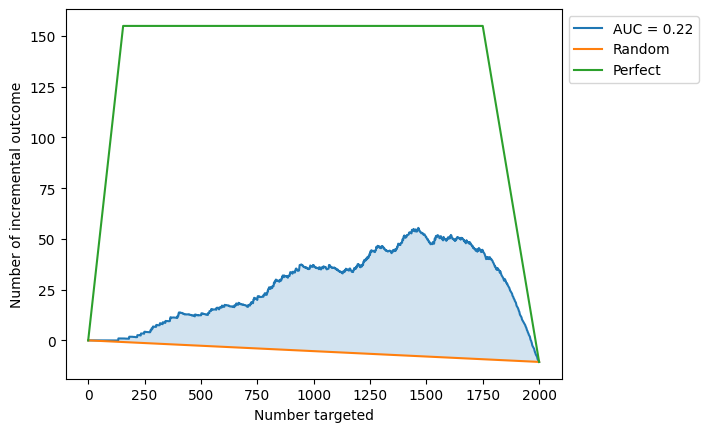

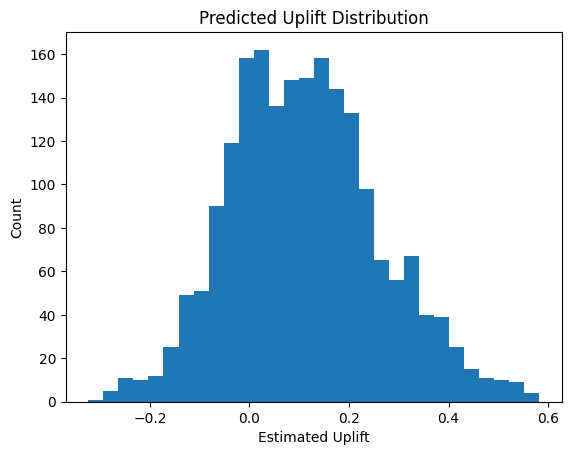

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklift.models import ClassTransformation
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve
from sklearn.model_selection import StratifiedKFold

# --- 1. Define base model and parameter grid ---
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 8],
    "min_samples_split": [2, 5, 10],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_score = -np.inf
best_params = None

# --- 2. Manual cross-validation loop ---
for params in ParameterGrid(param_grid):
    cv_scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        treat_tr, treat_val = (
            treatment_train.iloc[train_idx],
            treatment_train.iloc[val_idx],
        )

        uplift_model = ClassTransformation(
            estimator=RandomForestClassifier(random_state=42, **params)
        )
        uplift_model.fit(X_tr, y_tr, treat_tr)

        uplift_preds = uplift_model.predict(X_val)
        qini = qini_auc_score(y_val, uplift_preds, treat_val)
        cv_scores.append(qini)

    mean_qini = np.mean(cv_scores)

    print(f"Params: {params} | CV Qini AUC: {mean_qini:.4f}")

    if mean_qini > best_score:
        best_score = mean_qini
        best_params = params

print("✅ Best Params:", best_params)
print("✅ Best CV Qini AUC:", best_score)

# --- 3. Train best model on all training data ---
final_model = ClassTransformation(
    estimator=RandomForestClassifier(random_state=42, **best_params)
)
final_model.fit(X_train, y_train, treatment_train)

# --- 4. Evaluate on test data ---
uplift_preds = final_model.predict(X_test)
test_qini = qini_auc_score(y_test, uplift_preds, trmnt_test)

print(f"📈 Test Qini AUC: {test_qini:.4f}")

# --- 5. Plot Qini curve ---
plot_qini_curve(y_test, uplift_preds, trmnt_test)

# --- 6. Optional: show uplift distribution ---
plt.figure()
plt.hist(uplift_preds, bins=30)
plt.title("Predicted Uplift Distribution")
plt.xlabel("Estimated Uplift")
plt.ylabel("Count")
plt.show()

In [17]:
print(train.groupby("outreach")["churn"].mean())

outreach
0    0.207447
1    0.194026
Name: churn, dtype: float64


📈 Fixed Test Qini AUC: 0.2228


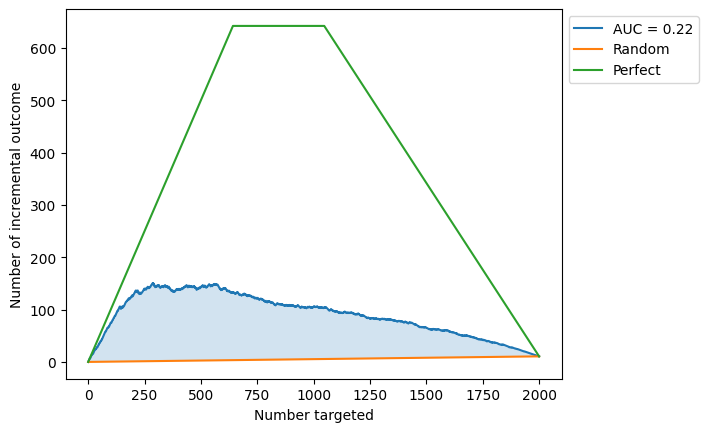

In [18]:
# Flip target so that 1 = retained (good outcome)
y_train_adj = 1 - y_train
y_test_adj = 1 - y_test

# Refit your best model
final_model.fit(X_train, y_train_adj, treatment_train)

uplift_preds = final_model.predict(X_test)
test_qini = qini_auc_score(y_test_adj, uplift_preds, trmnt_test)

print(f"📈 Fixed Test Qini AUC: {test_qini:.4f}")
plot_qini_curve(y_test_adj, uplift_preds, trmnt_test)